In [1]:
from utils import sanitize
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions, AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole

from rxnmapper import RXNMapper
rxnmapper = RXNMapper()

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

In [2]:
def make_rxn_sma(rxn_entry):
    '''
    Convert our standard rxn json
    entry into a reaction smarts
    '''
    reactants = sanitize(list(rxn_entry[0].values()))
    products = sanitize(list(rxn_entry[1].values()))
    sma = ".".join(reactants) + ">>" + ".".join(products)
    return sma

def atom_map(rxn_sma):
    return rxnmapper.get_attention_guided_atom_maps([rxn_sma])[0]['mapped_rxn']



def peri_rxn_ctr_mcs_v0(rxn_ctr_sma, mol1, mol2):
    pass

In [35]:
# Take reaction substrates

pred_rxn_sma = 'O=C(O)CCC(CC(=O)O)C(=O)O.\
                NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1\
                >>O=C(O)C=C(CCC(=O)O)C(=O)O.\
                NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

known_rxn_entry = [{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
                    'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
                    {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
                    'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

known_rxn_sma = make_rxn_sma(known_rxn_entry)

# Atom map
m_pred = atom_map(pred_rxn_sma)
m_known = atom_map(known_rxn_sma)

# Construct reaction objects
pred_rxn = AllChem.ReactionFromSmarts(m_pred, useSmiles=True)
known_rxn = AllChem.ReactionFromSmarts(m_known, useSmiles=True)

# Get reaction center

# Compute MCS seeded by reaction center

In [ ]:
'''
To do: 
    1. Get reaction json entries
    2. Make rxn sma (maintain order & copy of non-atom-mapped smiles / smarts)
    3. Get reacting atoms
    4. Filter out cofactors
    5. 
'''

In [36]:
pred_rxn.Initialize()
pred_rxn.GetReactingAtoms()

((3, 4, 5, 45, 46, 47), (3, 4))

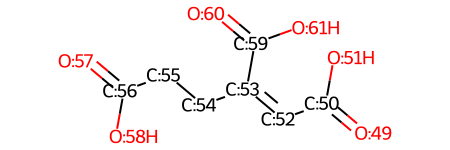

In [37]:
pred_rxn.GetProductTemplate(1)

In [38]:
known_rxn.Initialize()
known_rxn.GetReactingAtoms()

((1, 2), (3, 4, 5, 41, 42, 43))

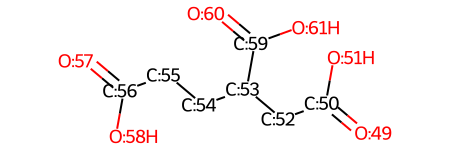

In [39]:
pred_rxn.GetReactantTemplate(1)

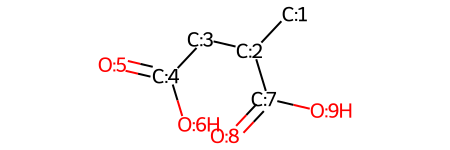

In [40]:
known_rxn.GetReactantTemplate(0)

# common atoms / bonds: 9 / 8


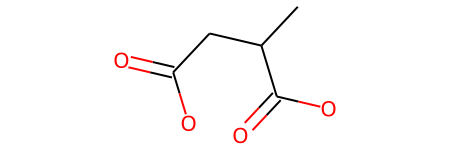

In [42]:
pred_reactant = pred_rxn.GetReactantTemplate(1)
known_reactant = known_rxn.GetReactantTemplate(0)
mols = [pred_reactant, known_reactant]
res = rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareOrderExact, matchValences=True)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

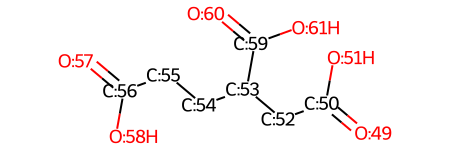

In [10]:
pred_rxn.GetReactantTemplate(1)

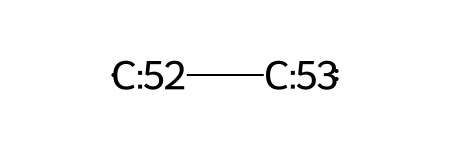

In [11]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetReactantTemplate(1)

Chem.MolFromSmiles(Chem.MolFragmentToSmiles(pred_mol, pridx))

In [12]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetProductTemplate(1)
pred_ss = Chem.MolFragmentToSmarts(pred_mol, pridx)
print(pred_ss)

kridx = known_rxn.GetReactingAtoms()[0]
known_mol = known_rxn.GetProductTemplate(0)
known_ss = Chem.MolFragmentToSmarts(known_mol, kridx)

print(known_ss)

[#6H:52]=[#6:53]
[#6:2]=[#6H:3]


# common atoms / bonds: 9 / 8


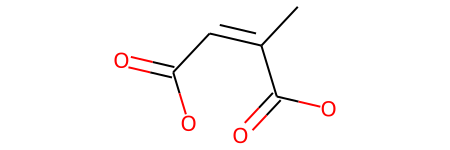

In [13]:
pred_product = pred_rxn.GetProductTemplate(1)
known_product = known_rxn.GetProductTemplate(0)
mols = [pred_product, known_product]
res = rdFMCS.FindMCS(mols, seedSmarts=known_ss)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

In [26]:
pridx = pred_rxn.GetReactingAtoms()[1]
pred_mol = pred_rxn.GetReactantTemplate(1)
pred_ss = Chem.MolFragmentToSmarts(pred_mol, pridx)
print(pred_ss)

kridx = known_rxn.GetReactingAtoms()[0]
known_mol = known_rxn.GetReactantTemplate(0)
known_ss = Chem.MolFragmentToSmarts(known_mol, kridx)

print(known_ss)

[#6H2:52]-[#6H:53]
[#6H:2]-[#6H2:3]


# common atoms / bonds: 9 / 8


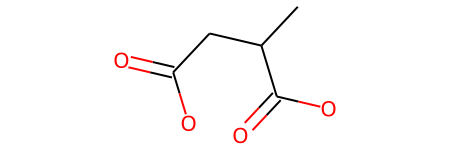

In [27]:
pred_reactant = pred_rxn.GetReactantTemplate(1)
known_reactant = known_rxn.GetReactantTemplate(0)
mols = [pred_reactant, known_reactant]
res = rdFMCS.FindMCS(mols, seedSmarts=known_ss)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

# common atoms / bonds: 1 / 0


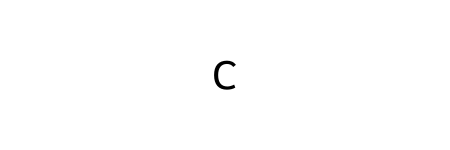

In [33]:
# Try challenge problem
Chem.MolToSmiles(pred_rxn.GetReactantTemplate(1))
smi1 = '[O:49]=[C:50]([OH:51])[CH2:52][CH:53]([CH2:54][CH2:55][C:56](=[O:57])[OH:58])[C:59](=[O:60])[OH:61]'
smi2 = '[CH:5]([CH2:6][CH2:7][C:8](=[O:9])[OH:10])[C:11](=[O:12])[OH:13]'
mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)


mols = [mol1, mol2]
res = rdFMCS.FindMCS(mols, seedSmarts=pred_ss, bondCompare=rdFMCS.BondCompare.CompareOrderExact, matchValences=True)
print(f"# common atoms / bonds: {res.numAtoms} / {res.numBonds}")
Chem.MolFromSmarts(res.smartsString)

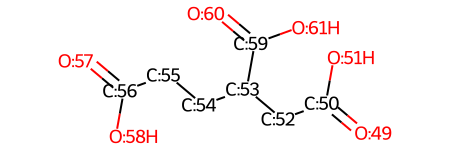

In [29]:
mol1

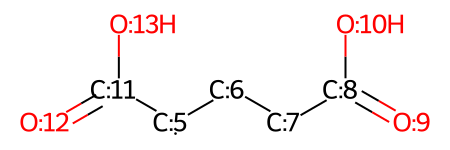

In [30]:
mol2